In [ ]:
'''
This notebook analyzes splicing and cleavage using LRS data and plots panels for Figure 5
'''

In [1]:
import os
import re

import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
import mygene
import scipy

from plotnine import *
import warnings
warnings.filterwarnings('ignore')

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42 # export pdfs with editable font types in Illustrator

In [3]:
# Link to annotation of all TES from UCSC Genome Browser
# TES = pd.read_csv('../annotation_files/active_transcripts_PAS.bed',
TES_all = pd.read_csv('mm10_TES.bed', 
                      delimiter = '\t', 
                      names =  ['chr', 'start', 'end', 'name', 'score', 'strand'])

# Link to active TSSs from PRO-seq
active_TSS = pd.read_csv('../annotation_files/active_TSS_PROseq_150_counts_mm10_VM20.txt', delimiter = '\t', header = 0)

# Links to input data: BED12 files that have been separated by splicing status
dataFiles = [
    '../Figure_2/all_spliced_reads.bed',
    '../Figure_2/partially_spliced_reads.bed',
    '../Figure_2/all_unspliced_reads.bed'
     ]

In [6]:
# # First, filter TES coordinates for only those that come from actively transcribed TSS's in MEL cells (as defined by PRO-seq)
TES_all['ENSMUST.ID'] = TES_all.name.str.split('_').str[0] # create column with txid from name column
TES = pd.merge(TES_all, active_TSS[['txname']], left_on = 'ENSMUST.ID', right_on = 'txname', how = 'inner', copy = False)

In [10]:
# Generate a file for doing bedtools coverage with a window around the TES

# set window length for generating window around splice sites
upstream = 100
downstream = 1000

# make a window around TES using defined window length
TES.loc[TES['strand'] == '+', 'window_start'] = (TES['start'] - upstream)
TES.loc[TES['strand'] == '-', 'window_start'] = (TES['start'] - downstream)
TES.loc[TES['strand'] == '+', 'window_end'] = (TES['end'] + downstream)
TES.loc[TES['strand'] == '-', 'window_end'] = (TES['end'] + upstream)

# return window start and end coordinates to intergers rather than floats
TES['window_start'] = TES['window_start'].astype(np.int64)
TES['window_end'] = TES['window_end'].astype(np.int64)
TES['window_start'] = TES['window_start'].astype(np.int64)
TES['window_end'] = TES['window_end'].astype(np.int64)

out_cols = ['chr', 'window_start', 'window_end', 'name', 'score', 'strand']

TES.to_csv('TES_window.bed', columns = out_cols, sep = '\t', index = False, header = False)

In [ ]:
# Calculate coverage over the TES window region using bedtools coverage (IN A TERMINAL WINDOW)
################################################################################################################
# bedtools coverage -s -d -a TES_window.bed -b ../Figure_2/all_spliced_reads.bed > all_spliced_cov.txt
# bedtools coverage -s -d -a TES_window.bed -b ../Figure_2/partially_spliced_reads.bed > partially_spliced_cov.txt
# bedtools coverage -s -d -a TES_window.bed -b ../Figure_2/all_unspliced_reads.bed > all_unspliced_cov.txt
################################################################################################################

In [24]:
# Define a function to read in output of bedtools coverage, rearrange columns and compute coverage in bins over a TES window
def get_coverage(file):
    filestring = file.split('/')[-1].split('_')[0:2]
    sample = '_'.join(filestring) # get sample ID from file name
    
    f = pd.read_csv(file, compression = 'gzip', sep = '\t', names = ['chr', 'start', 'end', 'name', 'score', 'strand', 'position', 'count'])
    
    f_grouped = f.groupby(['strand', 'position']).agg({'count':'sum'}) # group by position and strand, sum all counts
    
    tmp = f_grouped.unstack(level='strand') # separate plus and minus strand counts
    tmp_plus = tmp['count', '+'].to_frame() # convert both + and - strand series to dataframes
    tmp_minus = tmp['count', '-'].to_frame()
    tmp_minus = tmp_minus[::-1] # reverse order of the entries in the minus strand df
    tmp_minus['new_position'] = list(range(1,1102,1)) # reset the position to be 1-50 for the minus strand so it matches plus strand (flipped)
    df = pd.merge(tmp_plus, tmp_minus, left_index = True, right_on = 'new_position')

    df['total_count'] = df['count', '+'] + df['count', '-']
    df = df[['new_position', 'total_count']] # drop separate count columns for each strand
    df['rel_position'] = range(-100,1001,1) # add relative position around TES
    

    TES_val = df['total_count'].values[1] # get the coverage at the TES nucleotide position
    df['TES_pos_count'] = TES_val
    df['normalized_count'] = df['total_count'] / df['TES_pos_count'] # normalize coverage to TES coverage
    df['sample'] = sample # add sample identifier
    
    return df # return dataframe with position around TES ('normalized_count') and relative position around TES ('rel_position')

In [25]:
# get coverage for all_spliced, partially_spliced, and all_unspliced reads (each of these is slow)
df_cov_all_spliced = get_coverage('all_spliced_cov.txt.gz')
df_cov_partially_spliced = get_coverage('partially_spliced_cov.txt.gz')
df_cov_all_unspliced = get_coverage('all_unspliced_cov.txt.gz')

# concat all coverage dataframes together
df = pd.concat([df_cov_all_spliced, df_cov_partially_spliced, df_cov_all_unspliced])

In [26]:
# save coverage df
df.to_csv('coverage_matrix.txt', sep = '\t', index = False, header = True)

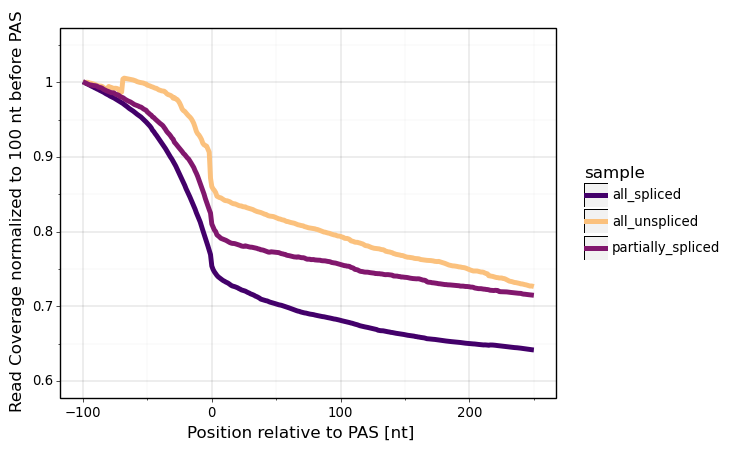

<ggplot: (8763634821497)>

In [27]:
# plot read coverage past PAS
my_colours = ['#43006A', '#FBC17D', '#81176D']

plt_PAS_coverage = (ggplot
     (data = df, mapping=aes( x = 'rel_position', y = 'normalized_count', colour = 'sample')) + 
      geom_line(size = 2, stat = 'identity') +
      scale_colour_manual(values = my_colours) + 
      theme_linedraw(base_size = 12) +
      xlab('Position relative to PAS [nt]') +
      ylim(0.6,1.05) +
      xlim(-100, 250) +
      ylab('Read Coverage normalized to 100 nt before PAS'))
plt_PAS_coverage

In [ ]:
# Determine 3'end cleavage status for each read and report per-read splicing status

# First get a list of active transcripts to overlap with reads to determine 3'end cleavage status
# For each read, use bedtools intersect to overlap 5' end with active transcripts identified in PRO-seq
# Then group the results by read - then check whether the 3' end is downstream of the PAS for that transcript
# if all overlaps with all transcripts are classified as uncleaved, then the read is called uncleaved

In [34]:
# Combine reads that have been classifed by splicing status into a single file, adding a new column to record splicing status
alldata = []
for file in dataFiles:
    df = pd.read_csv(file, delimiter = '\t', names =  ['chr', 'start', 'end', 'name', 'score', 'strand', 'readStart', 'readEnd', 'rgb', 'blocks', 'blockSizes', 'blockStarts'])
    splicing_status = file.split('/')[2]
    df['status'] = splicing_status
    alldata.append(df)
data = pd.concat(alldata)

In [35]:
# Define a function to get the 5' end coordiates for each read
def get_5end_coord(df):
    plus = df.loc[df['strand'] == '+']
    minus = df.loc[df['strand'] == '-']
    columns = ['chr', 'start', 'end', 'name', 'score', 'strand', 'readStart', 'readEnd', 'rgb', 'blocks', 'blockSizes', 'blockStarts', 'status']
    
    plus['end'] = plus['start'] + 1
    plus_out = plus[columns]
    
    minus['start'] = minus['end'] - 1
    minus_out = minus[columns]
    
    out = pd.concat([plus_out, minus_out])
    
    out.to_csv('data_combined_5end.bed', sep = '\t', index = False, header = False)

In [52]:
# Create a BED file with 5' end coordinate for combined long read data with splicing status classification
get_5end_coord(data)

In [ ]:
# Bedtools intersect 5' end of reads with active transcripts - write entire read a (IN A TERMINAL WINDOW)
################################################################################################################
# bedtools intersect -wo -s -a data_combined_5end.bed -b ../annotation_files/active_transcripts.bed > fiveEnd_intersect_active_transcripts.txt
################################################################################################################

In [36]:
# Read in result of bedtools intersect: r_ indicates read info, t_ indicates transcript annotation info
intersect = pd.read_csv('fiveEnd_intersect_active_transcripts.txt', 
                      delimiter = '\t', 
                      names =  ['r_chr', 'r_fiveEnd_start', 'r_fiveEnd_end', 'r_name', 'r_score', 'r_strand', 'r_readStart', 'r_readEnd', 'r_rgb', 'r_blocks', 'r_blockSizes', 'r_blockStarts', 'splicing_status', 't_chr', 't_start', 't_end', 't_name', 't_score', 't_strand', 'overlaps'])

In [37]:
# For reach row, compare whether or not the readEnd is past the transcript end, if so add 1 to cleavage status

distance_past_PAS = 50 # set cutoff distance for the read end to be past the annotated PAS

intersect_plus = intersect.loc[intersect['r_strand'] == "+"]
intersect_minus = intersect.loc[intersect['r_strand'] == "-"]

conditions_plus = [intersect_plus['r_readEnd'] > intersect_plus['t_end'].astype(int) + distance_past_PAS,
              intersect_plus['r_readEnd'] <= intersect_plus['t_end'].astype(int) + distance_past_PAS]
conditions_minus = [intersect_minus['r_readStart'] < intersect_minus['t_start'].astype(int) - distance_past_PAS,
              intersect_minus['r_readStart'] >= intersect_minus['t_start'].astype(int) - distance_past_PAS]

outputs = [1,0]
intersect_plus['uncleaved'] = np.select(conditions_plus, outputs, np.NaN)
intersect_minus['uncleaved'] = np.select(conditions_minus, outputs, np.NaN)
i = pd.concat([intersect_plus, intersect_minus])

g = i.groupby('r_name').agg({'uncleaved':'sum', # count the number of reads with 3' end past transcript PAS
                             'splicing_status':'first', # record splicing status for each read
                             'overlaps':'sum'}) # count the total number of transcript overlaps

g['cleavage_ratio'] = g['uncleaved']/g['overlaps'] # calculate how many times a transcript is called as uncleaved for all of the transcript annotations that it overlaps
g['cleavage_status'] = np.where(g['cleavage_ratio'] ==1,'uncleaved', 'cleaved') # only classify a read as "uncleaved" if the 3' end is past the PAS for ALL transcript annotations that it overlaps with

In [38]:
# Calculate fraction of reads that are in each splicing category for cleaved/uncleaved reads
total_uncleaved = len(g.loc[g['cleavage_status'] == 'uncleaved'])
total_cleaved = len(g.loc[g['cleavage_status'] == 'cleaved'])

all_spliced_cleaved = len(g.loc[(g['splicing_status'] == 'all_spliced_reads.bed') & (g['cleavage_status'] == 'cleaved')])
partially_spliced_cleaved = len(g.loc[(g['splicing_status'] == 'partially_spliced_reads.bed') & (g['cleavage_status'] == 'cleaved')])
all_unspliced_cleaved = len(g.loc[(g['splicing_status'] == 'all_unspliced_reads.bed') & (g['cleavage_status'] == 'cleaved')])

all_spliced_uncleaved = len(g.loc[(g['splicing_status'] == 'all_spliced_reads.bed') & (g['cleavage_status'] == 'uncleaved')])
partially_spliced_uncleaved = len(g.loc[(g['splicing_status'] == 'partially_spliced_reads.bed') & (g['cleavage_status'] == 'uncleaved')])
all_unspliced_uncleaved = len(g.loc[(g['splicing_status'] == 'all_unspliced_reads.bed') & (g['cleavage_status'] == 'uncleaved')])

data_list = [['uncleaved', 'all_spliced', all_spliced_uncleaved, total_uncleaved],
             ['uncleaved', 'partially_spliced', partially_spliced_uncleaved, total_uncleaved],
             ['uncleaved', 'all_unspliced', all_unspliced_uncleaved, total_uncleaved],
             ['cleaved', 'all_spliced', all_spliced_cleaved, total_cleaved],
             ['cleaved', 'partially_spliced', partially_spliced_cleaved, total_cleaved],
             ['cleaved', 'all_unspliced', all_unspliced_cleaved, total_cleaved]]

# Create the pandas DataFrame 
df = pd.DataFrame(data_list, columns = ['cleavage_status', 'splicing_status', 'count', 'total']) 
df['fraction'] = df['count']/df['total']
df

,cleavage_status,splicing_status,count,total,fraction
0,uncleaved,all_spliced,2725,5492,0.496176
1,uncleaved,partially_spliced,454,5492,0.082666
2,uncleaved,all_unspliced,2313,5492,0.421158
3,cleaved,all_spliced,117384,170179,0.689768
4,cleaved,partially_spliced,21890,170179,0.128629
5,cleaved,all_unspliced,30905,170179,0.181603


In [46]:
print('Number of Cleaved reads: ' + str(total_cleaved))
print('Number of Uncleaved reads: ' + str(total_uncleaved))

Number of Cleaved reads: 170179
Number of Uncleaved reads: 5492


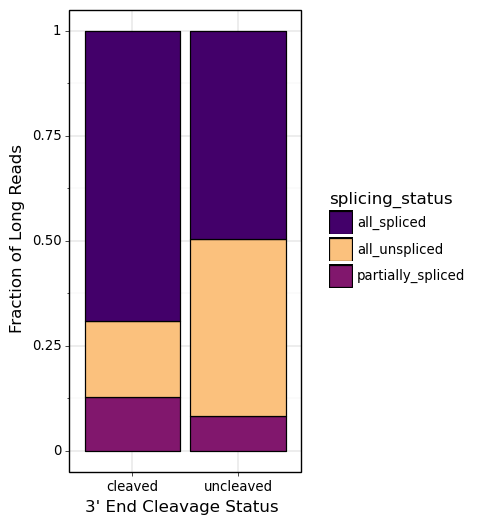

<ggplot: (8763634915433)>

In [39]:
my_colours = ['#43006A', '#FBC17D', '#81176D']
plt_splicing_cleavage_fraction = (ggplot
     (data=df, mapping=aes(x='cleavage_status', y='fraction', fill = 'splicing_status')) + 
      geom_bar(stat = 'identity', position = 'stack', colour = 'black') +
      theme_linedraw(base_size = 12) +
      theme(figure_size = (3,6)) +
      xlab("3' End Cleavage Status") +
      ylab('Fraction of Long Reads') +
      scale_fill_manual(values = my_colours)
    )
plt_splicing_cleavage_fraction

In [47]:
# save outputs
plt_PAS_coverage.save('plt_PAS_coverage.pdf')
plt_splicing_cleavage_fraction.save('plt_splicing_cleavage_fraction.pdf')
df.to_csv('splicing_cleavage_read_counts.txt', sep = '\t', header = True, index = False)